# The purpose of this notebook is to create a monte carlo simulation of blackjack

In [309]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Custom Modules.
from Game import Game
from Player import Player

# Custom Functions.
from RecursePlayer import recursePlayer,dealHouse,getReward,getValue
from Q_Learning import initQ,learnPolicy,evaluatePolicy,getBestAction,genEpisode
from Utils import dfBestMove

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Rewards Distribution

Given random gameplay, what are the expected reward for each state-action pair?

### Here, I can specifically state which combinations I want played. However, right now, I assume plentiful cards. Will not serve as optimal policy evaluation, but rather expected rewards given a state - action pair.

So, every combination is possible (hardcoded in), and the next card drawn is uniformly, with replacement. 

Might introduce some bias. Imagine player shows [2,2], the odds of them drawing another 2 should be lower, but this method does not say so.

I use discounted rewards. For example:
- Player shows 5, they hit to get 9, hit to get 12, hit to get 20, stay, and ends up winning the hand.
- I'm most interested in the move taken when player has 20.
- How I handle this is by using the gamma hyperparameter and discounting earlier moves more

Initialize the simulation

In [2]:
blackjack = Game(Player)
cardMap = blackjack.cardMap
cardValues = blackjack.cardValues
allCards = list(cardMap.values())

moves = ['stay','hit','double','surrender','split']

pairsSplit = {(c,c):i for i,c in enumerate(allCards)}
pairsSplit = {}
count = 0
for c in allCards :
    pairsSplit[(c,c)] = count
    if c not in [10,'J','Q'] :
        count += 1
    

# initialize arrays for totals + rewards
# dimensions are (m,a,p,h)
# - m : # of possible moves
# - a : useable ace or not
# - p : # of possible totals (includes 0,1,2,3 for simplicity), PLUS # of pairs
# - h : # of possible house face-up card (includes 0,1,2,3 for simplicity)

totals = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))
rewards = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))

gamma = .7

nTrials = 2000

Run the trail

In [48]:
for n in range(nTrials) :
    print('{} of {}'.format(n+1,nTrials),end='\r')
    for i in range(len(allCards)) :
        for j in range(i,len(allCards)) :
            cards = [allCards[i],allCards[j]]
            for h in range(len(allCards)) :
                houseCards,val,houseShow = dealHouse(allCards[h],cardMap,cardValues)
                seriesOut = recursePlayer(cards,allCards[h],cardMap,cardValues)

                for r in seriesOut :
                    if len(r)==0 :
                        totals[0,0,21,houseShow] += 1
                        rewards[0,0,21,houseShow] += 1.5
                        continue
                    reward = getReward(r,val)
                    
                    # I can discount earlier moves (hence reversing the order of moves)
                    # to more accurately reflect the benefit of hitting on smaller player cards shown.
                    for g,(playerShow,move,useableAce,pairSplit,nextVal) in enumerate(r[::-1]) :
                        indPlayer = playerShow
                        if pairSplit :
                            indPlayer = 22 + pairsSplit[tuple(pairSplit)]
                        totals[moves.index(move),int(useableAce),indPlayer,houseShow] += 1   
                        rewards[moves.index(move),int(useableAce),indPlayer,houseShow] += reward*gamma**g
            
            
normalized = np.zeros(totals.shape)
for m in range(len(moves)) :
    for i in [0,1] :
        # prevent division by zero, clip totals (shouldn't happen if # iterations is high enough)
        normalized[m][i] = rewards[m][i] / np.clip(totals[m][i],a_min=1,a_max=None)
            
            
        

In [49]:
np.save('normalized.npy',normalized)
normalized = np.load('normalized.npy')

In [50]:
noAce,useableAce,canSplit = dfBestMove(normalized,moves,pairsSplit,colorBox=True)

In [51]:
noAce

,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,St,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
8,Hi,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi
9,Do,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
11,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
12,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Su


In [52]:
useableAce

,2,3,4,5,6,7,8,9,10,11
13,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
15,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
16,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
17,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi
18,St,Do,Do,Do,Do,St,St,St,St,Hi
19,St,St,Do,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St
21,St,St,St,St,St,St,St,St,St,St


In [53]:
canSplit

,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi
"(4, 4)",Sp,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(7, 7)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(8, 8)",Sp,Sp,St,St,St,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,St,St,St,St,St,St,St,St
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Sp,Do,Do,Sp,Sp,Sp,Sp,Sp


# Policy Generation (Control)

Can I learn an optimal policy using Monte Carlo methods?
- Greedy Algorithm
    - Always take the best action. In my code, it's equivalent to setting epsilon to -1
- Epsilon-Greedy Algorithm
    - With probability=epsilon, randomly take action. Otherwise, take best action
    - I allow epsilon to decay through learning. Meaning, Always explore at first, then start to exploit more.
- Thompson Sampling methods.
    - In my situation, this is handled by setting always_random=True
    - The probability of an action is chosen according to the learned Q value distribution over actions.
    - I normalize Q values by taking softmax of Q values.


I find that always_random=True leads to faster training than in epsilon decay.

I store "bestQ" at each interval of evaluation (expensive function, since I simulate 1000 rounds to evaluate).
So, Backtracking will be performed until number of rounds is complete.

#### Simulate game play, gather totals and rewards, normalized rewards, and display best option.

In [246]:
card_comb_all = []
card_comb = [[c1,c2] for i,c1 in enumerate(allCards) for c2 in allCards[i:]]
all_comb = [[c1,c2] for c1 in allCards for c2 in allCards]
for c in card_comb :
    for a in all_comb :
        card_comb_all.append([[c]]+[a])

In [311]:
Q = {
    'name':'e-Greedy Decay 1',
    'epsilon_decay':.00001,
    'min_epsilon':.1,
    'evaluation':[],
    'q_max_eval': [],
}

Q = {
    'name':'Q Sampling',
    'epsilon_decay':.00001,
    'min_epsilon':.1,
    'evaluation':[],
    'q_max_eval': [],
}

nEpisodes = int(5e6) # number of rounds to train for.
nPlayers = 1 # number of players
gamma = .95 # decay hyperparameter. How much to discount sequential actions. Should be < 1.
lr = .0005 # learning rate
nDecks = 6 # number of decks in the game
ratioPenetrate = 4/6 # where the decks get penetrated, ie. 4/6'ths of the way through all decks
wagers = [1]*nPlayers # wagers per player "units"

nRoundsEvaluate = 1000 # number of hands to play during evaluation step

moves = ['stay','hit','split','double','surrender'] # valid moves.

earlyStop = False # whether we should early stop.
e = 10 # early stopping criterion. Number of "every" that have to pass without improvement.
# every = int(len(card_comb_all)/5) # interval to evaluate policy
every = 7500

# will intermittently store best Q values through evaluation
backtrack = False # whether to revert back to optimal Q values after training completes.

# epsilon or thompson
method = "thompson"

# since some combinations are so rare, they are hardly explored. 
# Setting to True will force these combinations to be used.
# I have found that without hardcoding, there is hardly any information in some of the states.
# Introduces some unrealistic scenarios (allows for n_card < 0, which won't happen at inference)
allow_hardcoded_cards = False 


In [313]:
# Generate random states according to a random policy

blackjack = Game(
    Player,
    allowHardCodedCards=allow_hardcoded_cards,
    shrinkDeck=True,
    nDecks=nDecks,
    ratioPenetrate=ratioPenetrate,
    verbose=False
)

r_states = []

while len(r_states) < 1000 :
    blackjack.initRound(wagers)
    blackjack.dealInit()
    s_s = genEpisode(blackjack,0,initQ(moves,allCards), 1, "epsilon")[-1]
    for s in s_s :
        p,h,a,split,c1,_ = s
        if split :
            r_states.append((c1,h,a,split))
        else :
            r_states.append((p,h,a,split))

In [314]:
blackjack = Game(
    Player,
    allowHardCodedCards=allow_hardcoded_cards,
    shrinkDeck=True,
    nDecks=nDecks,
    ratioPenetrate=ratioPenetrate,
    verbose=False
)

allCards = list(blackjack.cardMap.values())
Q['Q'] = initQ(moves,allCards)
Q_N_Count = initQ(moves,allCards) # Test to see how often state-action pairs are actually reached.

time_start = datetime.datetime.now()

r = 0
counter = 0
minPerformance = -10

while r < nEpisodes :
    
    # force exploration of space
    # since some combinations were never occuring, I still want some notion of how to move.
    # introduces some "error", as it's possible not enough cards are in the deck.
    # I say it's acceptable for 1 move, then a reshuffling will occur after.
    # I see better learning with this method anyways.
    card_comb_use = card_comb_all[r%len(card_comb_all)]

    blackjack.initRound(wagers)
    if allow_hardcoded_cards :
        blackjack.dealInit(hardcodedCards=card_comb_use) # force certain cards to be explored.
    else :
        blackjack.dealInit()
    if not blackjack.houseBlackjack : # If house blackjack, I don't really care to learn. Nothing we can do.
        eps = max(Q['min_epsilon'],np.exp(-Q['epsilon_decay']*r)) #exponential decay factor.
        learnPolicy(blackjack,Q['Q'],Q_N_Count,nPlayers,eps,gamma,lr,method)

    if not r%every :
        # Create new blackjack game for evaluation.
        blackjackEval = Game(
            Player,
            shrinkDeck=True,
            nDecks=nDecks,
            ratioPenetrate=ratioPenetrate,
            verbose=False
        )
        # Evaluation. This represents the avg reward, per hand, for the number of rounds specified.
        p_eval = np.mean(evaluatePolicy(blackjackEval,Q['Q'],wagers,nRoundsEvaluate)[-1])
        Q['evaluation'].append(p_eval)
        
        q_max = []
        for r_s in r_states :
            p,h,a,split = r_s
            if split :
                q_max.append(max(Q['Q']['canSplit'][(p,h,a)].values()))
            else :
                q_max.append(max(Q['Q']['noSplit'][(p,h,a)].values()))
        Q['q_max_eval'].append(np.mean(q_max))
                
        if not always_random :
            print('Method {} ---- {} of {} ---- EPS : {} ---- Score : {}'.format(
                Q['name'],
                r+1,
                nEpisodes,
                eps,
                p_eval
            ))
        else :
            print('Method {} ---- {} of {} ---- Score : {} ---- Time elapsed : {}'.format(
                Q['name'],
                r+1,
                nEpisodes,
                p_eval,
                datetime.datetime.now() - time_start
            ))

        if p < minPerformance : 
            counter += 1
        else :
            counter = 0
            if backtrack :
                bestQ = Q['Q'].copy() # "backtracking". This will be used as optimal Q value dict. 
        minPerformance = max(minPerformance,p)

    if (earlyStop) & (counter == e) :

        print('Early Stopping at Round {}.'.format(r))
        break

    r += 1
if not backtrack : # without backtracking, just take final Q values.
    bestQ = Q['Q'].copy()

Method Q Sampling ---- 1 of 5000000 ---- Score : -0.4165 ---- Time elapsed : 0:00:00.297577
Method Q Sampling ---- 7501 of 5000000 ---- Score : -0.1085 ---- Time elapsed : 0:00:02.689099
Method Q Sampling ---- 15001 of 5000000 ---- Score : -0.078 ---- Time elapsed : 0:00:05.112737
Method Q Sampling ---- 22501 of 5000000 ---- Score : -0.045 ---- Time elapsed : 0:00:07.537078
Method Q Sampling ---- 30001 of 5000000 ---- Score : -0.012 ---- Time elapsed : 0:00:09.937285
Method Q Sampling ---- 37501 of 5000000 ---- Score : -0.022 ---- Time elapsed : 0:00:12.346026
Method Q Sampling ---- 45001 of 5000000 ---- Score : -0.06 ---- Time elapsed : 0:00:14.745175
Method Q Sampling ---- 52501 of 5000000 ---- Score : -0.0265 ---- Time elapsed : 0:00:17.170210
Method Q Sampling ---- 60001 of 5000000 ---- Score : -0.063 ---- Time elapsed : 0:00:19.585513
Method Q Sampling ---- 67501 of 5000000 ---- Score : -0.0035 ---- Time elapsed : 0:00:21.992958
Method Q Sampling ---- 75001 of 5000000 ---- Score :

Method Q Sampling ---- 645001 of 5000000 ---- Score : 0.057 ---- Time elapsed : 0:03:28.976347
Method Q Sampling ---- 652501 of 5000000 ---- Score : -0.0025 ---- Time elapsed : 0:03:31.370412
Method Q Sampling ---- 660001 of 5000000 ---- Score : -0.05 ---- Time elapsed : 0:03:33.823417
Method Q Sampling ---- 667501 of 5000000 ---- Score : -0.041 ---- Time elapsed : 0:03:36.220975
Method Q Sampling ---- 675001 of 5000000 ---- Score : -0.017 ---- Time elapsed : 0:03:38.574252
Method Q Sampling ---- 682501 of 5000000 ---- Score : -0.0005 ---- Time elapsed : 0:03:40.968285
Method Q Sampling ---- 690001 of 5000000 ---- Score : -0.0305 ---- Time elapsed : 0:03:43.336160
Method Q Sampling ---- 697501 of 5000000 ---- Score : 0.0015 ---- Time elapsed : 0:03:45.742134
Method Q Sampling ---- 705001 of 5000000 ---- Score : 0.015 ---- Time elapsed : 0:03:48.158469
Method Q Sampling ---- 712501 of 5000000 ---- Score : 0.0465 ---- Time elapsed : 0:03:50.559244
Method Q Sampling ---- 720001 of 5000000

Method Q Sampling ---- 1290001 of 5000000 ---- Score : 0.031 ---- Time elapsed : 0:06:55.730781
Method Q Sampling ---- 1297501 of 5000000 ---- Score : 0.046 ---- Time elapsed : 0:06:58.138710
Method Q Sampling ---- 1305001 of 5000000 ---- Score : 0.0555 ---- Time elapsed : 0:07:00.591938
Method Q Sampling ---- 1312501 of 5000000 ---- Score : 0.022 ---- Time elapsed : 0:07:03.037151
Method Q Sampling ---- 1320001 of 5000000 ---- Score : 0.05 ---- Time elapsed : 0:07:05.456287
Method Q Sampling ---- 1327501 of 5000000 ---- Score : -0.0585 ---- Time elapsed : 0:07:07.867362
Method Q Sampling ---- 1335001 of 5000000 ---- Score : 0.0225 ---- Time elapsed : 0:07:10.251196
Method Q Sampling ---- 1342501 of 5000000 ---- Score : -0.0125 ---- Time elapsed : 0:07:12.633630
Method Q Sampling ---- 1350001 of 5000000 ---- Score : -0.01 ---- Time elapsed : 0:07:15.035039
Method Q Sampling ---- 1357501 of 5000000 ---- Score : 0.0805 ---- Time elapsed : 0:07:17.418677
Method Q Sampling ---- 1365001 of 

Method Q Sampling ---- 1927501 of 5000000 ---- Score : -0.0085 ---- Time elapsed : 0:10:19.413562
Method Q Sampling ---- 1935001 of 5000000 ---- Score : 0.0385 ---- Time elapsed : 0:10:21.797008
Method Q Sampling ---- 1942501 of 5000000 ---- Score : -0.0405 ---- Time elapsed : 0:10:24.204001
Method Q Sampling ---- 1950001 of 5000000 ---- Score : 0.028 ---- Time elapsed : 0:10:26.592216
Method Q Sampling ---- 1957501 of 5000000 ---- Score : 0.0155 ---- Time elapsed : 0:10:28.989902
Method Q Sampling ---- 1965001 of 5000000 ---- Score : 0.071 ---- Time elapsed : 0:10:31.392477
Method Q Sampling ---- 1972501 of 5000000 ---- Score : 0.017 ---- Time elapsed : 0:10:33.799969
Method Q Sampling ---- 1980001 of 5000000 ---- Score : -0.0255 ---- Time elapsed : 0:10:36.190182
Method Q Sampling ---- 1987501 of 5000000 ---- Score : 0.004 ---- Time elapsed : 0:10:38.573955
Method Q Sampling ---- 1995001 of 5000000 ---- Score : 0.1145 ---- Time elapsed : 0:10:40.991971
Method Q Sampling ---- 2002501 

Method Q Sampling ---- 2565001 of 5000000 ---- Score : 0.0655 ---- Time elapsed : 0:13:43.655788
Method Q Sampling ---- 2572501 of 5000000 ---- Score : 0.0265 ---- Time elapsed : 0:13:46.110597
Method Q Sampling ---- 2580001 of 5000000 ---- Score : 0.005 ---- Time elapsed : 0:13:48.561127
Method Q Sampling ---- 2587501 of 5000000 ---- Score : -0.0295 ---- Time elapsed : 0:13:51.010134
Method Q Sampling ---- 2595001 of 5000000 ---- Score : 0.053 ---- Time elapsed : 0:13:53.483941
Method Q Sampling ---- 2602501 of 5000000 ---- Score : -0.0315 ---- Time elapsed : 0:13:55.949892
Method Q Sampling ---- 2610001 of 5000000 ---- Score : -0.0465 ---- Time elapsed : 0:13:58.363336
Method Q Sampling ---- 2617501 of 5000000 ---- Score : 0.0825 ---- Time elapsed : 0:14:00.824590
Method Q Sampling ---- 2625001 of 5000000 ---- Score : -0.0115 ---- Time elapsed : 0:14:03.220274
Method Q Sampling ---- 2632501 of 5000000 ---- Score : -0.023 ---- Time elapsed : 0:14:05.646163
Method Q Sampling ---- 26400

Method Q Sampling ---- 3202501 of 5000000 ---- Score : 0.06 ---- Time elapsed : 0:17:08.680741
Method Q Sampling ---- 3210001 of 5000000 ---- Score : 0.0545 ---- Time elapsed : 0:17:11.039681
Method Q Sampling ---- 3217501 of 5000000 ---- Score : 0.0165 ---- Time elapsed : 0:17:13.428164
Method Q Sampling ---- 3225001 of 5000000 ---- Score : -0.014 ---- Time elapsed : 0:17:15.801356
Method Q Sampling ---- 3232501 of 5000000 ---- Score : 0.0285 ---- Time elapsed : 0:17:18.193486
Method Q Sampling ---- 3240001 of 5000000 ---- Score : 0.025 ---- Time elapsed : 0:17:20.546387
Method Q Sampling ---- 3247501 of 5000000 ---- Score : -0.009 ---- Time elapsed : 0:17:22.948539
Method Q Sampling ---- 3255001 of 5000000 ---- Score : -0.001 ---- Time elapsed : 0:17:25.332360
Method Q Sampling ---- 3262501 of 5000000 ---- Score : 0.015 ---- Time elapsed : 0:17:27.697704
Method Q Sampling ---- 3270001 of 5000000 ---- Score : 0.0005 ---- Time elapsed : 0:17:30.069059
Method Q Sampling ---- 3277501 of 

Method Q Sampling ---- 3840001 of 5000000 ---- Score : -0.0035 ---- Time elapsed : 0:20:31.510465
Method Q Sampling ---- 3847501 of 5000000 ---- Score : 0.0295 ---- Time elapsed : 0:20:33.905922
Method Q Sampling ---- 3855001 of 5000000 ---- Score : -0.0665 ---- Time elapsed : 0:20:36.300178
Method Q Sampling ---- 3862501 of 5000000 ---- Score : 0.011 ---- Time elapsed : 0:20:38.676831
Method Q Sampling ---- 3870001 of 5000000 ---- Score : 0.0585 ---- Time elapsed : 0:20:41.056116
Method Q Sampling ---- 3877501 of 5000000 ---- Score : 0.0155 ---- Time elapsed : 0:20:43.430369
Method Q Sampling ---- 3885001 of 5000000 ---- Score : -0.0045 ---- Time elapsed : 0:20:45.811058
Method Q Sampling ---- 3892501 of 5000000 ---- Score : -0.0235 ---- Time elapsed : 0:20:48.191093
Method Q Sampling ---- 3900001 of 5000000 ---- Score : -0.028 ---- Time elapsed : 0:20:50.547905
Method Q Sampling ---- 3907501 of 5000000 ---- Score : 0.0665 ---- Time elapsed : 0:20:52.947399
Method Q Sampling ---- 3915

Method Q Sampling ---- 4477501 of 5000000 ---- Score : 0.0025 ---- Time elapsed : 0:23:54.309624
Method Q Sampling ---- 4485001 of 5000000 ---- Score : 0.0285 ---- Time elapsed : 0:23:56.676813
Method Q Sampling ---- 4492501 of 5000000 ---- Score : -0.034 ---- Time elapsed : 0:23:59.061338
Method Q Sampling ---- 4500001 of 5000000 ---- Score : 0.026 ---- Time elapsed : 0:24:01.437196
Method Q Sampling ---- 4507501 of 5000000 ---- Score : 0.0265 ---- Time elapsed : 0:24:03.799901
Method Q Sampling ---- 4515001 of 5000000 ---- Score : 0.132 ---- Time elapsed : 0:24:06.199279
Method Q Sampling ---- 4522501 of 5000000 ---- Score : 0.0785 ---- Time elapsed : 0:24:08.616820
Method Q Sampling ---- 4530001 of 5000000 ---- Score : 0.072 ---- Time elapsed : 0:24:10.996832
Method Q Sampling ---- 4537501 of 5000000 ---- Score : -0.0205 ---- Time elapsed : 0:24:13.384787
Method Q Sampling ---- 4545001 of 5000000 ---- Score : 0.0195 ---- Time elapsed : 0:24:15.755171
Method Q Sampling ---- 4552501 o

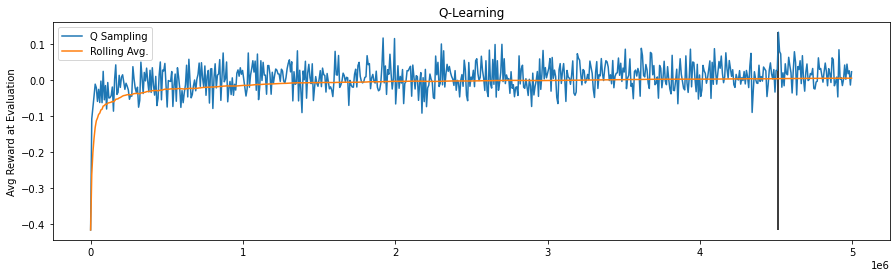

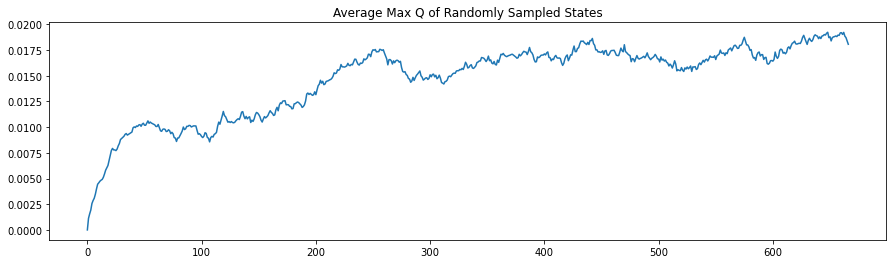

In [315]:
plt.figure(figsize=(15,4))
plt.plot(
    np.arange(0,len(Q['evaluation']))*every,
    Q['evaluation'],
    label=Q['name']
)
plt.plot(
    np.arange(0,len(Q['evaluation']))*every,
    np.cumsum(Q['evaluation']) / np.arange(1,len(Q['evaluation'])+1),
    label='Rolling Avg.'
)
plt.vlines(x=np.argmax(Q['evaluation'])*every,ymin=min(Q['evaluation']),ymax=max(Q['evaluation']),color='k')
plt.title("Q-Learning")
plt.ylabel("Avg Reward at Evaluation")
plt.legend()
plt.show()


plt.figure(figsize=(15,4))
plt.title("Average Max Q of Randomly Sampled States")
plt.plot(Q['q_max_eval'])
plt.show()

In [316]:
np.save('Q',bestQ)
Qlearned = np.load('Q.npy',allow_pickle=True).item()

### Evaluate new policy, as well as a random one, and a simple one.

It is apparent that the learned policy performs better in practice than a random one, and a "simple" one. In the "simple" one, I create a basic strategy where the player hits until they have >17

In [317]:
# I found online that this gameplay was optimal.

# I need to favor splitting, surrendering, doubling, if they are possible actions (ie, first move of the game).
# I'll consider Stay/Hit as fallback moves, and denote them as 0.5
# Since the action space gets narrowed during training/inference, the value of 1 is ignored for double/surrender/split

acceptedQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
for split,s_pairs in acceptedQ.items() :
    for s,vals in s_pairs.items() :
        p,h,a = s
        if split=="canSplit" :
            if p == "A" :
                p = 11
            if p <= 3 :
                vals["hit"] = 0.5
                if h <= 7 :
                    vals["split"] = 1
            if p == 4 :
                vals["hit"] = 0.5
                if h in [5,6] :
                    vals["split"] = 1
            if p == 5 :
                vals["hit"] = 0.5
                if h <= 9 :
                    vals["double"] = 1
            if p == 6 :
                if h in [4,5,6] :
                    vals["stay"] = 0.5
                else :
                    vals["hit"] = 0.5
                if h <= 6 :
                    vals["split"] = 1
            if p == 7 :
                if h <= 6 :
                    vals["stay"] = 0.5
                else :
                    vals["hit"] = 0.5
                if h <= 7 :
                    vals["split"] = 1
            if p == 8 :
                if h <= 6 :
                    vals["stay"] = 0.5
                else :
                    vals["hit"] = 0.5
                vals["split"] = 1
            if p == 9 :
                vals["stay"] = 0.5
                if h in [2,3,4,5,6,8,9] :
                    vals["split"] = 1
            if p == 10 :
                vals["stay"] = 0.5
            if p == 11 :
                vals["split"] = 1
        else :
            if not a :
                if p <= 8 :
                    vals["hit"] = 0.5
                if p == 9 :
                    vals["hit"] = 0.5
                    if h in [3,4,5,6] :
                        vals["double"] = 1
                if p == 10 :
                    vals["hit"] = 0.5
                    if h <= 9 :
                        vals["double"] = 1
                if p == 11 :
                    vals["hit"] = 0.5
                    vals["double"] = 1
                if p == 12 :
                    if 4 <= h <= 6 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                if p in [13,14] :
                    if h <= 6 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                if p == 15 :
                    if h <= 6 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                    if h == 10 :
                        vals["surrender"] = 1
                if p == 16 :
                    if h <= 6 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                    if h >= 9 :
                        vals["surrender"] = 1
                if p >= 17 :
                    vals["stay"] = 0.5
            else :
                if p in [13,14] :
                    vals["hit"] = 0.5
                    if h in [5,6] :
                        vals["double"] = 1
                if p in [15,16] :
                    vals["hit"] = 0.5
                    if h in [4,5,6] :
                        vals["double"] = 1
                if p == 17 :
                    vals["hit"] = 0.5
                    if h in [3,4,5,6] :
                        vals["double"] = 1
                if p == 18 :
                    if h <= 8 :
                        vals["stay"] = 0.5
                    else :
                        vals["hit"] = 0.5
                    if h <= 6 :
                        vals["double"] = 1
                if p == 19 :
                    vals["stay"] = 0.5
                    if h == 6 :
                        vals["double"] = 1
                if p == 20 :
                    vals["stay"] = 0.5  

Generating Random Rewards...
Generating Learned Rewards Deterministically...
Generating Accepted Rewards... (found online to be optimal play)
Generating Meh Rewards...
Done


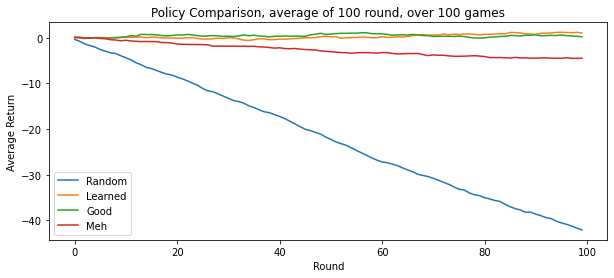

In [318]:
nRoundsEvaluate = 100 # number of rounds to play
nIterations = 100 # number of times to play above number of rounds (average is taken)

print('Generating Random Rewards...')
randQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
randomRewards = np.mean(
    [np.cumsum(evaluatePolicy(blackjack,randQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
    axis=0
)

print('Generating Learned Rewards Deterministically...')
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
try : # if Qlearned has been defined, read in from file, else use the Q dict trained in this notebook.
    learnedRewards = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,Qlearned,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
        axis=0
    )
except :
    learnedRewards = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,bestQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
        axis=0
    )
    
print("Generating Accepted Rewards... (found online to be optimal play)")
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
acceptedRewards = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,acceptedQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
        axis=0
    )
    
print('Generating Meh Rewards...')
somewhatSmartQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
for split,s_pairs in somewhatSmartQ.items() :
    for s,vals in s_pairs.items() :
        p,h,a = s
        if split=='canSplit' :
            if p == 'A' :
                p = 12
            else :
                p = p*2
        if p >= 17 :
            vals['stay'] = 1
        else :
            vals['hit'] = 1

blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
mehRewards = np.mean(
    [np.cumsum(evaluatePolicy(blackjack,somewhatSmartQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
    axis=0
)
print('Done')

plt.figure(figsize=(10,4))
plt.title(f'Policy Comparison, average of {nRoundsEvaluate} round, over {nIterations} games')
plt.plot(randomRewards,label='Random')
plt.plot(learnedRewards,label='Learned')
plt.plot(acceptedRewards,label='Good')
plt.plot(mehRewards,label='Meh')
plt.xlabel('Round')
plt.ylabel('Average Return')
plt.legend()
plt.show()

Focusing in on learned + accepted policies


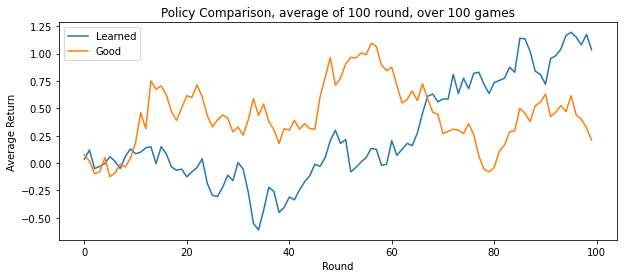

In [319]:
print("Focusing in on learned + accepted policies")
plt.figure(figsize=(10,4))
plt.title(f'Policy Comparison, average of {nRoundsEvaluate} round, over {nIterations} games')
plt.plot(learnedRewards,label='Learned')
plt.plot(acceptedRewards,label='Good')
plt.xlabel('Round')
plt.ylabel('Average Return')
plt.legend()
plt.show()

In [320]:
print("We can observe the Expected Value of Blackjack following these policies:")
print("This takes into account the effect of doubling down, splitting, and blackjacks (impacting wager / winnings)\n")
print("Play Randomly:")
print(f"\t{(randomRewards[-1]/nRoundsEvaluate):.4f} units net per round\n")
print("Mimicing the House:")
print(f"\t{(mehRewards[-1]/nRoundsEvaluate):.4f} units net per round\n")
print("Following Accepted Policy:")
print(f"\t{(acceptedRewards[-1]/nRoundsEvaluate):.4f} units net per round\n")
print("Following Learned Policy:")
print(f"\t{(learnedRewards[-1]/nRoundsEvaluate):.4f} units net per round\n")

We can observe the Expected Value of Blackjack following these policies:
This takes into account the effect of doubling down, splitting, and blackjacks (impacting wager / winnings)

Play Randomly:
	-0.4208 units net per round

Mimicing the House:
	-0.0450 units net per round

Following Accepted Policy:
	0.0021 units net per round

Following Learned Policy:
	0.0103 units net per round



### While sampling helped in training Q values, it's clear that we should deterministically take actions best on best Q value at that state/action pair.

Below, I show the cummulative rewards for a different players playing blackjack for many rounds according to our learned policy.

There is clearly a ton of randomness going on. This is the nature of blackjack.

Important to note that we are able to minimize risk through this learned policy. We go from a net -0.4 units lost per round with a random policy, to achieving what seems to be no-loss per round, on average.

**This doesn't even take card count into account**

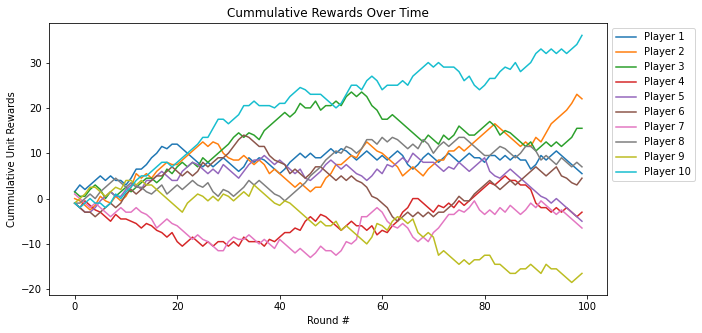

In [321]:
plt.figure(figsize=(10,5))

for i in range(10) :
    blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
    try : # if Qlearned has been defined, read in from file, else use the Q dict trained in this notebook.
        r = np.cumsum(evaluatePolicy(blackjack,Qlearned,wagers,nRoundsEvaluate)[0])
    except :
        r = np.cumsum(evaluatePolicy(blackjack,bestQ,wagers,nRoundsEvaluate)[0])
    plt.plot(r,label='Player {}'.format(i+1))
plt.legend(bbox_to_anchor=[1, 1])
plt.title('Cummulative Rewards Over Time')
plt.xlabel('Round #')
plt.ylabel('Cummulative Unit Rewards')
plt.show()

### Give an example of playing a hand according to learned policy.

You can see the sequence of events taken by the player, the sequence of events taken by the house, the outcome, and the unit reward

In [322]:
blackjack = Game(Player,verbose=False)

blackjack.initRound(wagers=[1])
blackjack.dealInit()
player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
houseShow = blackjack.getHouseShow(showValue=True)

print('Player Cards / Moves:')
while not player.isDone() :

    playerShow,canSplit,useableAce,card1 = player.getValue()

    policy = player.getValidMoves(houseShow)
    policy = [p for p in policy if p!='insurance']
    try :
        if canSplit :
            move = getBestAction(Qlearned['canSplit'][(card1,houseShow,useableAce)],policy,-1,"epsilon")
        else :
            move = getBestAction(Qlearned['noSplit'][(playerShow,houseShow,useableAce)],policy,-1,"epsilon")
    except :
        if canSplit :
            move = getBestAction(bestQ['canSplit'][(card1,houseShow,useableAce)],policy,-1,"epsilon")
        else :
            move = getBestAction(bestQ['noSplit'][(playerShow,houseShow,useableAce)],policy,-1,"epsilon")
    print(player.cards,move)
    
    blackjack.stepPlayer(player,move)

if move not in ['stay','surrender'] :
    print(player.cards)

blackjack.stepHouse()

print('\nHouse Cards / Moves:')
print(blackjack.house.cards)
print('\nResult:')
blackjack.getResults()

Player Cards / Moves:
[[8, 5]] stay

House Cards / Moves:
[[5, 'A', 6, 3, 'Q']]

Result:


([['win']], [1])

## Evaluation

### First I can show the Value function

Two ways:
- Deterministic Action. Select best action. ie. P=1 for best action, else P=0
- Random Action. Best action is selected according to normalized q values

$V_{\pi}(s)$ tells us, according to a policy $\pi$, how "good" is it to be in state $s$
$$
V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]
$$

$Q_{\pi}(s,a)$ tells us, according to a policy $\pi$, how "good" is it to be in state $s$ and take action $a$
$$
Q_{\pi}(s,a) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right]
$$

We can relate $V$ and $Q$ by taking marginal expections over $a$

$$V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]$$

$$V_{\pi}(s) = E_a\left[E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right] \right]$$

$$V_{\pi}(s) = E_a\left[Q_{\pi}(s,a)\right]$$

$$V_{\pi}(s) = \sum_{a}\pi(s,a)Q(s,a)$$

Where $\pi(s,a)$ is the probability of taking action $a$ in state $s$

In my case, I allow for randomization in action during Q learning. However, in evaluation, I always take the optimal action, which is deterministic

In practice, the action is taken that maximizes the Q value given the current state, deterministically.

In [69]:
Qlearned = np.load('Q.npy',allow_pickle=True).item()

In [323]:
fill = np.empty((3,21+1,11+1),dtype='O')
value_det = np.zeros((3,21+1,11+1))

In [324]:
# Two ways to define value function
# 1. Deterministic. Pick best action
# 2. Random. Pick best action according to probability, which is normalized from possible q-values

for k,v in Qlearned['noSplit'].items() :
    p,h,a = k
    fill[int(a),p,h] = max(v,key=v.get)[:2].title()
    value_det[int(a),p,h] = max(v.values()) # Deterministic    
for k,v in Qlearned['canSplit'].items() :
    p,h,a = k
    if not isinstance(p,int) :
        p = 11
    fill[2,p,h] = max(v,key=v.get)[:2].title()
    value_det[2,p,h] = max(v.values()) # Deterministic    

### Below I am plotting 3d visualizations of our Reward function.

#### We assume that the P=1 for taking the best action, and P=0 otherwise. We don't learn transition probabilities in this model-free method, so we always take the best action in our environment

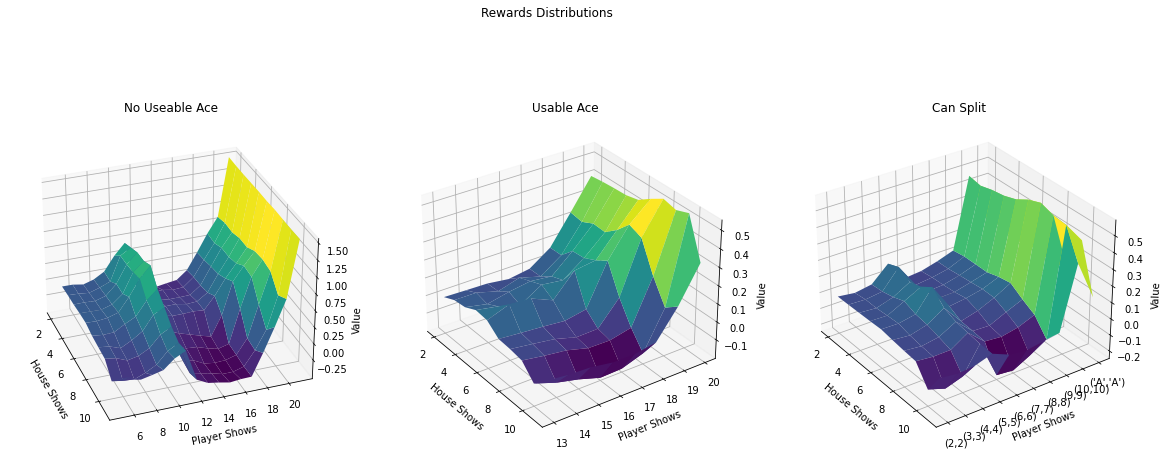

In [325]:
fig = plt.figure(figsize=(20,8))
fig.suptitle('Rewards Distributions')
ax = fig.add_subplot(131, projection='3d')
ax.set_title('No Useable Ace')

noAceMesh = value_det[0][5:,2:]
x,y = np.meshgrid(range(2,12),range(5,22))
ax.plot_surface(x, y, noAceMesh, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.view_init(azim=-20)
ax.set_xlabel('House Shows')
ax.set_ylabel('Player Shows')
ax.set_zlabel('Value')

ax = fig.add_subplot(132, projection='3d')
ax.set_title('Usable Ace')
usableAceMesh = value_det[1][13:21,2:]
x,y = np.meshgrid(range(2,12),range(13,21))

ax.plot_surface(x, y, usableAceMesh, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.view_init(azim=-35)
ax.set_xlabel('House Shows')
ax.set_ylabel('Player Shows')
ax.set_zlabel('Value')

ax = fig.add_subplot(133, projection='3d')
ax.set_title('Can Split')

canSplitMesh = value_det[2][2:12,2:]
x,y = np.meshgrid(range(2,12),range(2,12))
ticks = ["({},{})".format(p,p) if p < 11 else "('A','A')" for p in range(2,12)]
ax.set(yticks=range(2,12), yticklabels=ticks)
ax.plot_surface(x, y, canSplitMesh, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.view_init(azim=-35)
ax.set_xlabel('House Shows')
ax.set_ylabel('Player Shows')
ax.set_zlabel('Value')

plt.subplots_adjust(hspace=0, wspace=0.2)

plt.show()

In [330]:
value_det = np.zeros((3,21+1,11+1))

for k,v in Q_N_Count['noSplit'].items() :
    p,h,a = k
    value_det[int(a),p,h] = sum(v.values()) # Deterministic    
for k,v in Q_N_Count['canSplit'].items() :
    p,h,a = k
    if not isinstance(p,int) :
        p = 11
    value_det[2,p,h] = sum(v.values()) # Deterministic  

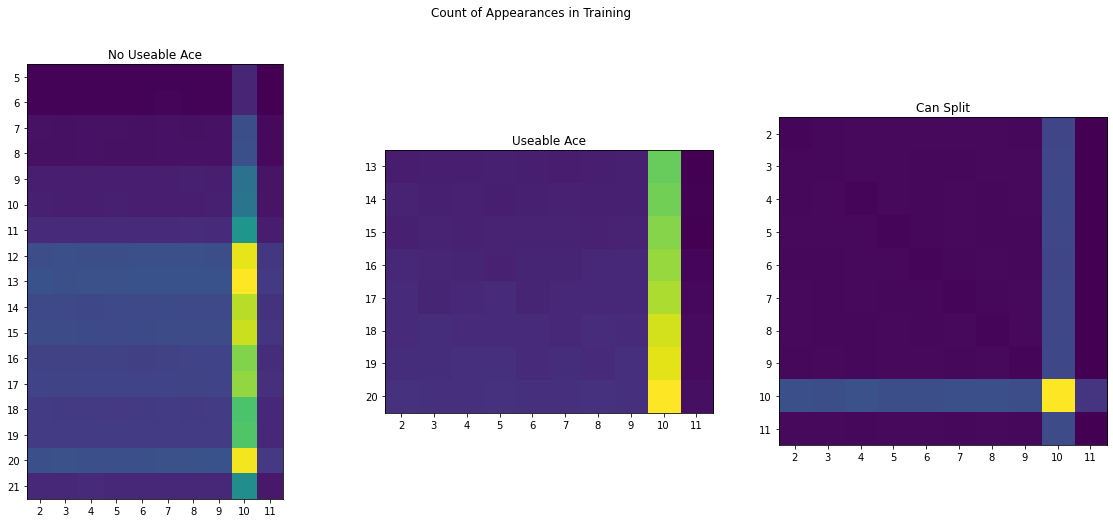

In [372]:
fig = plt.figure(figsize=(20,8))
fig.suptitle('Count of Appearances in Training')

ax = fig.add_subplot(131)
ax.set_title('No Useable Ace')
ax.imshow(value_det[0][5:,2:])
ax.set(yticks=range(17), yticklabels=range(5,22))
ax.set(xticks=range(10), xticklabels=range(2,12))

ax = fig.add_subplot(132)
ax.set_title('Useable Ace')
ax.imshow(value_det[1][13:21,2:])
ax.set(yticks=range(8), yticklabels=range(13,21))
ax.set(xticks=range(10), xticklabels=range(2,12))

ax = fig.add_subplot(133)
ax.set_title('Can Split')
ax.imshow(value_det[2][2:12,2:])
ax.set(yticks=range(10), yticklabels=range(2,12))
ax.set(xticks=range(10), xticklabels=range(2,12))

plt.show()

In [326]:
colorMap = {'St':'blue','Hi':'green','Do':'red','Su':'grey','Sp':'yellow'}
noAce = pd.DataFrame(fill[0])
noAce = noAce.iloc[5:][range(2,12)].style.applymap(lambda x: 'background-color: %s' % colorMap[x])
noAce

,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
8,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
9,Do,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Do,Hi,Hi
11,Do,Do,Do,Do,Do,Do,Do,Do,Hi,Hi
12,Hi,Hi,Hi,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi


In [327]:
usableAce = pd.DataFrame(fill[1])
usableAce = usableAce.iloc[13:21][range(2,12)].style.applymap(lambda x: 'background-color: %s' % colorMap[x])
usableAce

,2,3,4,5,6,7,8,9,10,11
13,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Do,Do,Hi,Do,Do,Hi,Hi,Hi,Hi,Hi
15,Do,Hi,Do,Hi,Do,Hi,Hi,Hi,Hi,Hi
16,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
17,Do,Hi,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
18,St,Do,Do,Do,Do,St,St,Hi,Hi,Hi
19,St,St,St,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St


In [328]:
canSplit = pd.DataFrame(fill[2])
canSplit = canSplit.iloc[2:12][range(2,12)]
canSplit.index = [(p,p) if p < 11 else ('A','A') for p in range(2,12)]
canSplit = canSplit.style.applymap(lambda x: 'background-color: %s' % colorMap[x])
canSplit

,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Hi,Hi,Sp,Sp,Sp,Sp,Hi,Hi,Sp
"(3, 3)",Hi,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Sp,Hi
"(4, 4)",Hi,Hi,Do,Do,Hi,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Do,Hi,Hi
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi
"(7, 7)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(8, 8)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,St,St,St,St,St,Sp,St,Sp
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp


## Next, I want to incorporate "card count" into the model. This makes the space too large. The solution to this is approximating the Q learning function, through deep learning methods.